# YOLO detector

A model to detect if and where autograph signatures are present in an image of a document.  
The model is trained on few examples labelled with bounding boxes of signatures.

In [1]:
import os, random, shutil, glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO

In [2]:
%matplotlib inline

In [ ]:
# torch.cuda.is_available = lambda: False

# check GPU
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))



CUDA available: False


## Dataset

### Dataset inspection

In [4]:
DATASET_NAME = './datasets/custom1labelled'

labels_df = pd.read_csv(DATASET_NAME+'/labels.csv')
labels_df.head()

FileNotFoundError: [Errno 2] No such file or directory: './datasets/custom1labelled/labels.csv'

In [ ]:
for i in range(3):
    info = labels_df.iloc[i]
    bbox = (info['bbox_x'], info['bbox_y'], info['bbox_width'], info['bbox_height'])
    bbox = np.array([[bbox[0], bbox[1]], 
                     [bbox[0]+bbox[2], bbox[1]], 
                     [bbox[0]+bbox[2], bbox[1]+bbox[3]], 
                     [bbox[0], bbox[1]+bbox[3]]])
    img = cv2.imread(f'{DATASET_NAME}/{info['image_name']}', cv2.IMREAD_COLOR)
    img = cv2.polylines(img, [bbox], True, (0, 255, 0), 3, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()

### Dataset preparation

In [ ]:
csv_path = "datasets/custom1yolo/annotations.csv"
images_dir = "datasets/custom1yolo/images"
output_labels_dir = "datasets/custom1yolo/labels"

# create labels dir if not exist
os.makedirs(output_labels_dir, exist_ok=True)

# ---- load CSV ----
df = pd.read_csv(csv_path)

# get class names & make an index mapping
class_names = sorted(df['label_name'].unique())
class_to_id = {name: i for i, name in enumerate(class_names)}

print("Classes:", class_to_id)

# ---- convert rows ----
for img_name, group in df.groupby('image_name'):
    label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + ".txt")
    with open(label_path, "w") as f:
        for _, row in group.iterrows():
            cls_id = class_to_id[row['label_name']]

            x_center = (row['bbox_x'] + row['bbox_width'] / 2) / row['image_width']
            y_center = (row['bbox_y'] + row['bbox_height'] / 2) / row['image_height']
            w = row['bbox_width'] / row['image_width']
            h = row['bbox_height'] / row['image_height']

            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

print(f"✅ Done. Labels saved to: {output_labels_dir}")

In [6]:
csv_path = "datasets/snps/labels.csv"
images_dir = "datasets/snps/imgs"
output_labels_dir = "datasets/snps/labels"

# create labels dir if not exist
os.makedirs(output_labels_dir, exist_ok=True)

# ---- load CSV ----
df = pd.read_csv(csv_path)

# get class names & make an index mapping
class_names = sorted(df['label_name'].unique())
class_to_id = {name: i for i, name in enumerate(class_names)}

print("Classes:", class_to_id)

# ---- convert rows ----
for img_name, group in df.groupby('image_name'):
    label_path = os.path.join(output_labels_dir, os.path.splitext(img_name)[0] + ".txt")
    with open(label_path, "w") as f:
        for _, row in group.iterrows():
            cls_id = class_to_id[row['label_name']]

            x_center = (row['bbox_x'] + row['bbox_width'] / 2) / row['image_width']
            y_center = (row['bbox_y'] + row['bbox_height'] / 2) / row['image_height']
            w = row['bbox_width'] / row['image_width']
            h = row['bbox_height'] / row['image_height']

            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

print(f"✅ Done. Labels saved to: {output_labels_dir}")

Classes: {'signature': 0}
✅ Done. Labels saved to: datasets/snps/labels


### Dataset split

In [ ]:
images = glob.glob(f"{images_dir}/*.jpg")
random.shuffle(images)

split_ratio = 0.8
train = images[:int(len(images)*split_ratio)]
val = images[int(len(images)*split_ratio):]

for split, files in [("train", train), ("val", val)]:
    os.makedirs(f"{images_dir}/{split}", exist_ok=True)
    os.makedirs(f"{output_labels_dir}/{split}", exist_ok=True)
    for img_path in files:
        name = os.path.basename(img_path)
        lbl_path = f"{output_labels_dir}/{name.replace('.jpg','.txt')}"
        shutil.copy(img_path, f"{images_dir}/{split}/{name}")
        try:
            shutil.copy(lbl_path, f"{output_labels_dir}/{split}/{name.replace('.jpg','.txt')}")
        except FileNotFoundError:
            pass

## Pretrained Model

In [4]:
data_file = 'datasets/custom1yolo/data.yaml'

# choose model backbone/weights: 'yolov8n.pt','yolov8s.pt','yolov8m.pt','yolov8l.pt','yolov8x.pt'
# 'n' is nano (fast), 'x' is largest (more accurate, heavier)
pretrained_weights = 'yolov8n.pt'
model = YOLO(pretrained_weights)

### Training

In [5]:
model.train(
    data=data_file,   # path to data yaml
    imgsz=512,          # image size
    epochs=10,
    batch=4,
    lr0=0.1,
    patience=5,        # early stopping patience
    save=True,          # save best weights
    project='runs',  # where to store runs
    name='exp1',        # subfolder name
    exist_ok=False,
)


New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.220  Python-3.13.9 torch-2.7.1+cu118 CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/custom1yolo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.1, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp15, nbs=64, nms=Fal

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to C:\Users\matti\Desktop\code\python\AI\CV\signatureDetection\runs\exp15\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.1' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to C:\Users\matti\Desktop\code\python\AI\CV\signatureDetection\runs\exp15
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


       1/10         0G      2.294      4.424      1.763          4        512: 100% ━━━━━━━━━━━━ 8/8 0.8it/s 10.2s1.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.6it/s 1.2s3.3s
                   all          9         14    0.00333      0.643    0.00324   0.000934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10         0G       2.27       4.22      1.676          2        512: 100% ━━━━━━━━━━━━ 8/8 1.2it/s 6.9s0.7ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.1it/s 1.0s2.9s
                   all          9         14     0.0037      0.714    0.00654    0.00174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10         0G      1.797      3.589      1.416          2        512: 100% ━━━━━━━━━━━━ 8/8 1.2it/s 6.5s0.7ss
                 Class     Images  Instances     

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000226184F0F50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048048

### Inference


image 1/1 c:\Users\matti\Desktop\code\python\AI\CV\signatureDetection\datasets\snps\imgs\2_001.png: 512x384 (no detections), 52.9ms
Speed: 2.0ms preprocess, 52.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 384)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (3509, 2481)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))


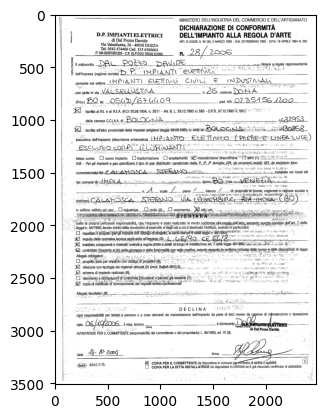

In [9]:
inf_img_path = 'datasets/snps/imgs/2_001.png'
# inf_img_path = 'datasets/custom1yolo/images/train/101.jpg'

results = model.predict(source=inf_img_path, imgsz=512, conf=0.1, save=False)
res = results[0]
print(res.boxes)

img = cv2.imread(inf_img_path)
for box in res.boxes.xyxy.cpu().numpy():
    x1,y1,x2,y2 = map(int, box[:4])
    conf = box[4] if box.shape[0] > 4 else None
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(img)
plt.show()

## From scratch